# FERC Form 1 Example Plots
This notebook grabs some information about large steam plants and their fuel consumption from our FERC Form 1 database, and generates a few example plots visualizing a few statistics on a per-plant basis.

In [1]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join('..','..')))
from pudl import pudl, ferc1, eia923, settings, constants
from pudl import models, models_ferc1, models_eia923
from pudl import clean_eia923, clean_ferc1, clean_pudl
from pudl import analysis
import numpy as np
import pandas as pd
import sqlalchemy as sa
import matplotlib.pyplot as plt
%matplotlib inline
%load_ext autoreload
%autoreload
pudl_engine = pudl.db_connect_pudl()
plt.style.use('ggplot')

In [2]:
pudl_tables = models.PUDLBase.metadata.tables
utilities_ferc1 = pudl_tables['utilities_ferc1']
utilities_eia923 = pudl_tables['utilities_eia923']
plants_ferc1 = pudl_tables['plants_ferc1']
plants_eia923 = pudl_tables['plants_eia923']
plants_pudl = pudl_tables['plants']
util_plant_assn = pudl_tables['util_plant_assn']
frc_eia923 = pudl_tables['fuel_receipts_costs_eia923']
gf_eia923 = pudl_tables['generation_fuel_eia923']
fuel_ferc1 = pudl_tables['fuel_ferc1']
steam_ferc1 = pudl_tables['plants_steam_ferc1']

In [3]:
def get_fuel_ferc1_df():
    fuel_ferc1_select = sa.sql.select([
        fuel_ferc1.c.report_year,
        utilities_ferc1.c.respondent_id,
        utilities_eia923.c.operator_id,
        utilities_ferc1.c.util_id_pudl,
        utilities_ferc1.c.respondent_name,
        plants_ferc1.c.plant_id_pudl,
        plants_eia923.c.plant_id,
        fuel_ferc1.c.plant_name,
        fuel_ferc1.c.fuel,
        fuel_ferc1.c.fuel_qty_burned,
        fuel_ferc1.c.fuel_avg_mmbtu_per_unit,
        fuel_ferc1.c.fuel_cost_per_unit_burned,
        fuel_ferc1.c.fuel_cost_per_unit_delivered,
        fuel_ferc1.c.fuel_cost_per_mmbtu,
        fuel_ferc1.c.fuel_cost_per_mwh,
        fuel_ferc1.c.fuel_mmbtu_per_mwh]).\
        where(sa.sql.and_(
            utilities_ferc1.c.respondent_id == fuel_ferc1.c.respondent_id,
            plants_ferc1.c.respondent_id == fuel_ferc1.c.respondent_id,
            plants_ferc1.c.plant_name == fuel_ferc1.c.plant_name,
            utilities_eia923.c.util_id_pudl == utilities_ferc1.c.util_id_pudl,
            plants_eia923.c.plant_id_pudl == plants_ferc1.c.plant_id_pudl,
            fuel_ferc1.c.fuel.in_(['oil','gas','coal'])
        ))

    return(pd.read_sql(fuel_ferc1_select, pudl_engine))
fuel_df = get_fuel_ferc1_df()

In [4]:
def get_steam_ferc1_df():
    steam_ferc1_select = sa.sql.select([
        steam_ferc1.c.report_year,
        utilities_ferc1.c.respondent_id,
        utilities_eia923.c.operator_id,
        utilities_ferc1.c.util_id_pudl,
        utilities_ferc1.c.respondent_name,
        plants_ferc1.c.plant_id_pudl,
        plants_eia923.c.plant_id,
        steam_ferc1.c.plant_name,
        steam_ferc1.c.total_capacity_mw,
        steam_ferc1.c.net_generation_mwh,
        steam_ferc1.c.expns_operations,
        steam_ferc1.c.expns_fuel,
        steam_ferc1.c.expns_coolants,
        steam_ferc1.c.expns_steam,
        steam_ferc1.c.expns_steam_other,
        steam_ferc1.c.expns_transfer,
        steam_ferc1.c.expns_electric,
        steam_ferc1.c.expns_misc_power,
        steam_ferc1.c.expns_rents,
        steam_ferc1.c.expns_allowances,
        steam_ferc1.c.expns_engineering,
        steam_ferc1.c.expns_structures,
        steam_ferc1.c.expns_boiler,
        steam_ferc1.c.expns_plants,
        steam_ferc1.c.expns_misc_steam,
        steam_ferc1.c.expns_production_total,
        steam_ferc1.c.expns_per_mwh]).\
        where(sa.sql.and_(
            utilities_ferc1.c.respondent_id == steam_ferc1.c.respondent_id,
            plants_ferc1.c.respondent_id == steam_ferc1.c.respondent_id,
            plants_ferc1.c.plant_name == steam_ferc1.c.plant_name,
            utilities_eia923.c.util_id_pudl == utilities_ferc1.c.util_id_pudl,
            plants_eia923.c.plant_id_pudl == plants_ferc1.c.plant_id_pudl,
        ))

    return(pd.read_sql(steam_ferc1_select, pudl_engine))
steam_df = get_steam_ferc1_df()

In [5]:
fuel_df['total_mmbtu'] = fuel_df['fuel_qty_burned']*fuel_df['fuel_avg_mmbtu_per_unit']
fuel_df['total_fuel_cost_mmbtu'] = fuel_df['fuel_cost_per_mmbtu']*fuel_df['total_mmbtu']
fuel_df['total_fuel_cost_units'] = fuel_df['fuel_cost_per_unit_burned']*fuel_df['fuel_qty_burned']

In [6]:
# These are useful fields shared by fuel and plant dataframes:
ferc_merge_fields = ['report_year',
                     'respondent_id',
                     'operator_id',
                     'util_id_pudl',
                     'respondent_name',
                     'plant_id_pudl',
                     'plant_id',
                     'plant_name']

index_cols = ['util_id_pudl','plant_id_pudl','report_year']

ferc_merge = fuel_df[ferc_merge_fields].copy()
ferc_merge = ferc_merge.drop_duplicates(subset=index_cols)

fuel_by_plant_year = fuel_df.groupby(index_cols)

# Fields we want to pull in from the fuel dataframe, by plant_id_pudl
fuel_merge_fields = ['total_mmbtu',
                     'total_fuel_cost_units',
                     'total_fuel_cost_mmbtu']

for field in fuel_merge_fields:
    ferc_merge = ferc_merge.merge(pd.DataFrame(fuel_by_plant_year[field].sum()),
                                  left_on=index_cols,
                                  right_index=True)

# Fields we're ultimately trying to get from the steam dataframe:
steam_merge_fields = ['total_capacity_mw',
                      'net_generation_mwh',
                      'expns_fuel',
                      'expns_nonfuel_production',
                      'expns_nonproduction']

# But first we need to calculate the non-fuel production and non-production expenses:
expns_corr = analysis.ferc1_expns_corr(pudl_engine, capacity_factor=0.6)

steam_bad_cols = ['expns_fuel', 'expns_per_mwh','expns_production_total']
# Remove the expns_* columns that we don't want to aggregate
for key in steam_bad_cols:
    x = expns_corr.pop(key, None)
    
# For now using correlation with net_generation > 0.5 as indication of "production" vs. non-produciton
expns_nonfuel_production = [k for k in expns_corr.keys() if expns_corr[k] >= 0.5]
expns_nonproduction = [k for k in expns_corr.keys() if expns_corr[k] < 0.5]

steam_df['expns_nonfuel_production'] = steam_df[expns_nonfuel_production].copy().sum(axis=1)
steam_df['expns_nonproduction'] = steam_df[expns_nonproduction].copy().sum(axis=1)
    
steam_by_plant_year = steam_df.groupby(index_cols)

for field in steam_merge_fields:
    ferc_merge = ferc_merge.merge(pd.DataFrame(steam_by_plant_year[field].sum()),
                                  left_on=index_cols,
                                  right_index=True)

In [7]:
ferc_merge['expns_fuel_per_mwh'] = ferc_merge['expns_fuel'] / ferc_merge['net_generation_mwh']
ferc_merge['expns_nonfuel_production_per_mwh'] = ferc_merge['expns_nonfuel_production'] / ferc_merge['net_generation_mwh']
ferc_merge['expns_nonproduction_per_mwh'] = ferc_merge['expns_nonproduction'] / ferc_merge['net_generation_mwh']
ferc_merge['expns_nonproduction_per_mw'] = ferc_merge['expns_nonproduction'] / ferc_merge['total_capacity_mw']
ferc_merge['mmbtu_per_mwh'] = ferc_merge['total_mmbtu'] / ferc_merge['net_generation_mwh']
ferc_merge['capacity_factor'] = ferc_merge['net_generation_mwh'] / (8760 * ferc_merge['total_capacity_mw'])
ferc_merge['expns_total'] = ferc_merge['expns_fuel'] + \
                            ferc_merge['expns_nonfuel_production'] + \
                            ferc_merge['expns_nonproduction']
ferc_merge['expns_total_per_mwh'] = ferc_merge['expns_total'] / ferc_merge['net_generation_mwh']

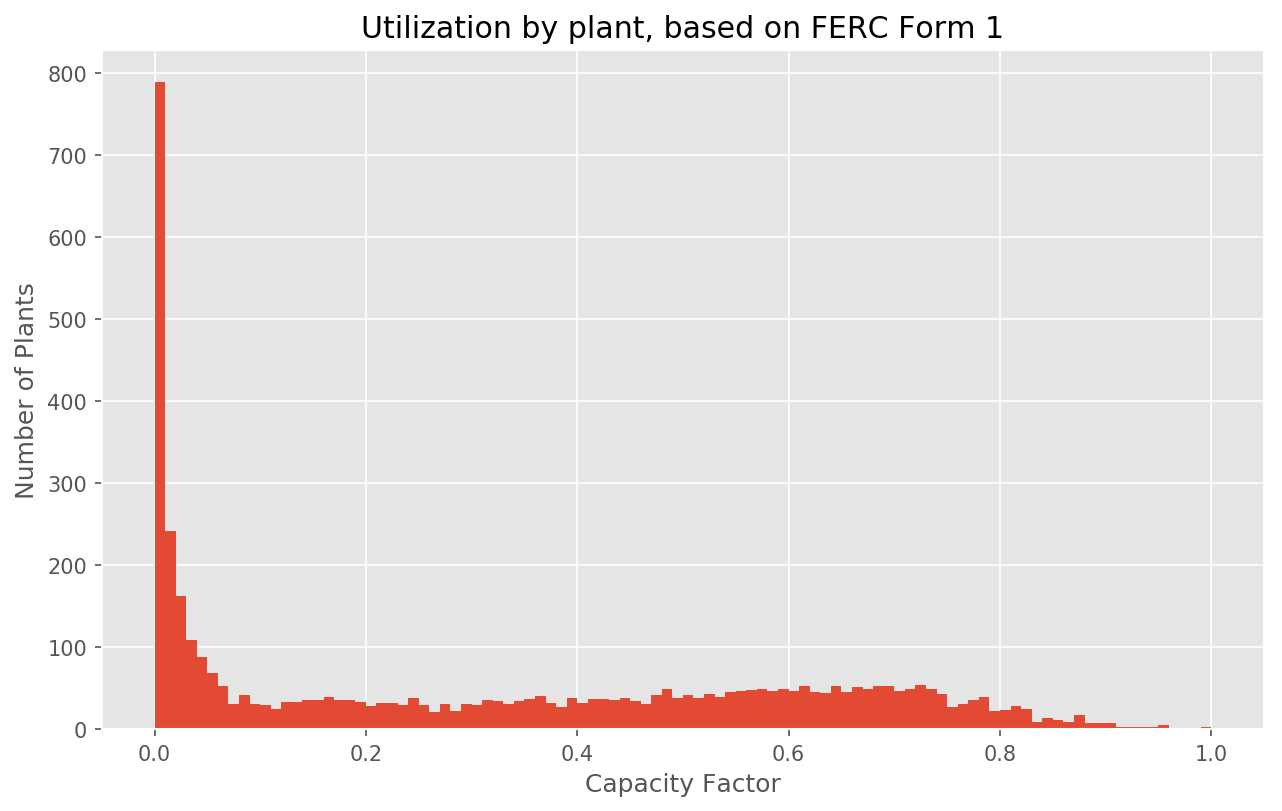

In [8]:
cap_fac = ferc_merge[ferc_merge['capacity_factor'].apply(np.isfinite)]['capacity_factor']
fig, (ax) = plt.subplots(ncols=1, nrows=1)
fig.set_figwidth(10)
fig.set_figheight(6)
fig.set_dpi(150)
plt.grid(b=True)
ax.set_ylabel("Number of Plants")
ax.set_xlabel("Capacity Factor")
ax.set_title("Utilization by plant, based on FERC Form 1")
ax.hist(cap_fac, bins=100, range=(0,1));

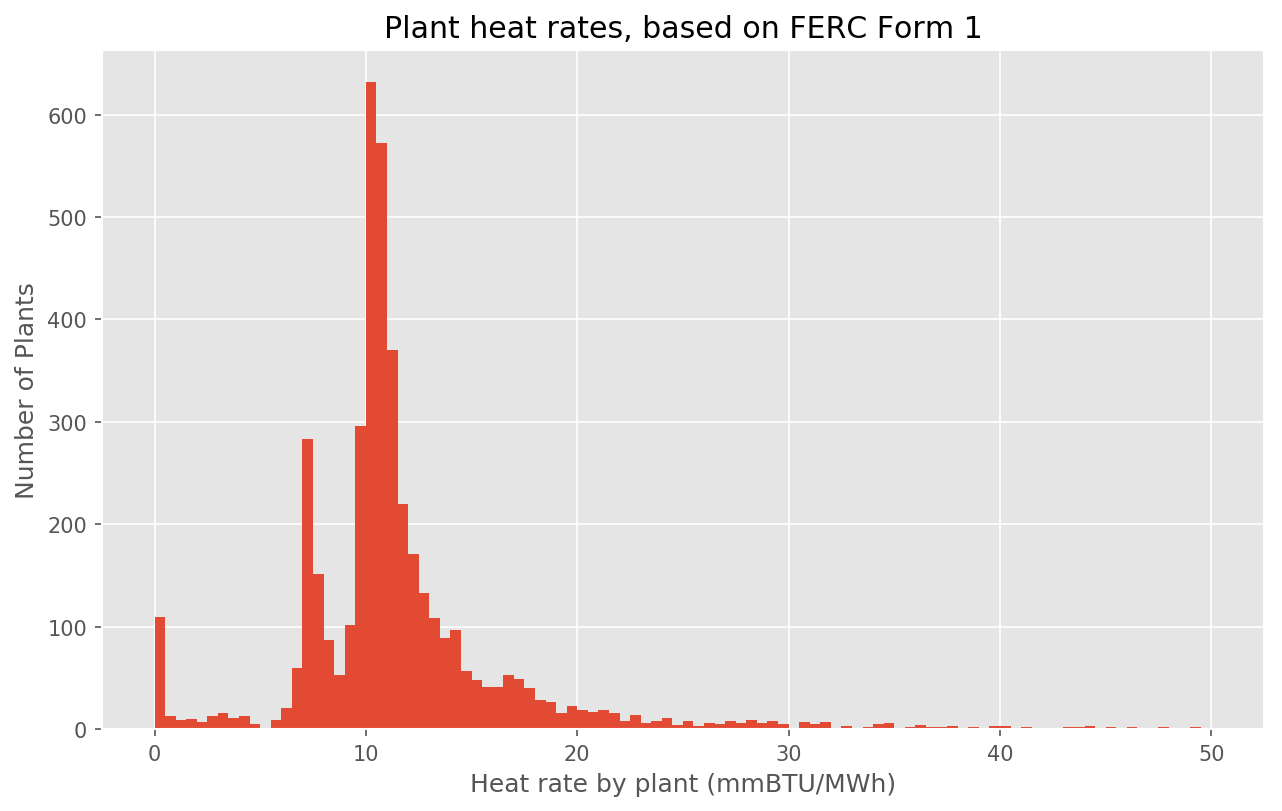

In [9]:
fig, (ax) = plt.subplots(ncols=1, nrows=1)
fig.set_figwidth(10)
fig.set_figheight(6)
fig.set_dpi(150)
plt.grid(b=True)
ax.set_ylabel("Number of Plants")
ax.set_xlabel("Heat rate by plant (mmBTU/MWh)")
ax.set_title("Plant heat rates, based on FERC Form 1")
ax.hist(ferc_merge['mmbtu_per_mwh'], bins=100, range=(0,50));

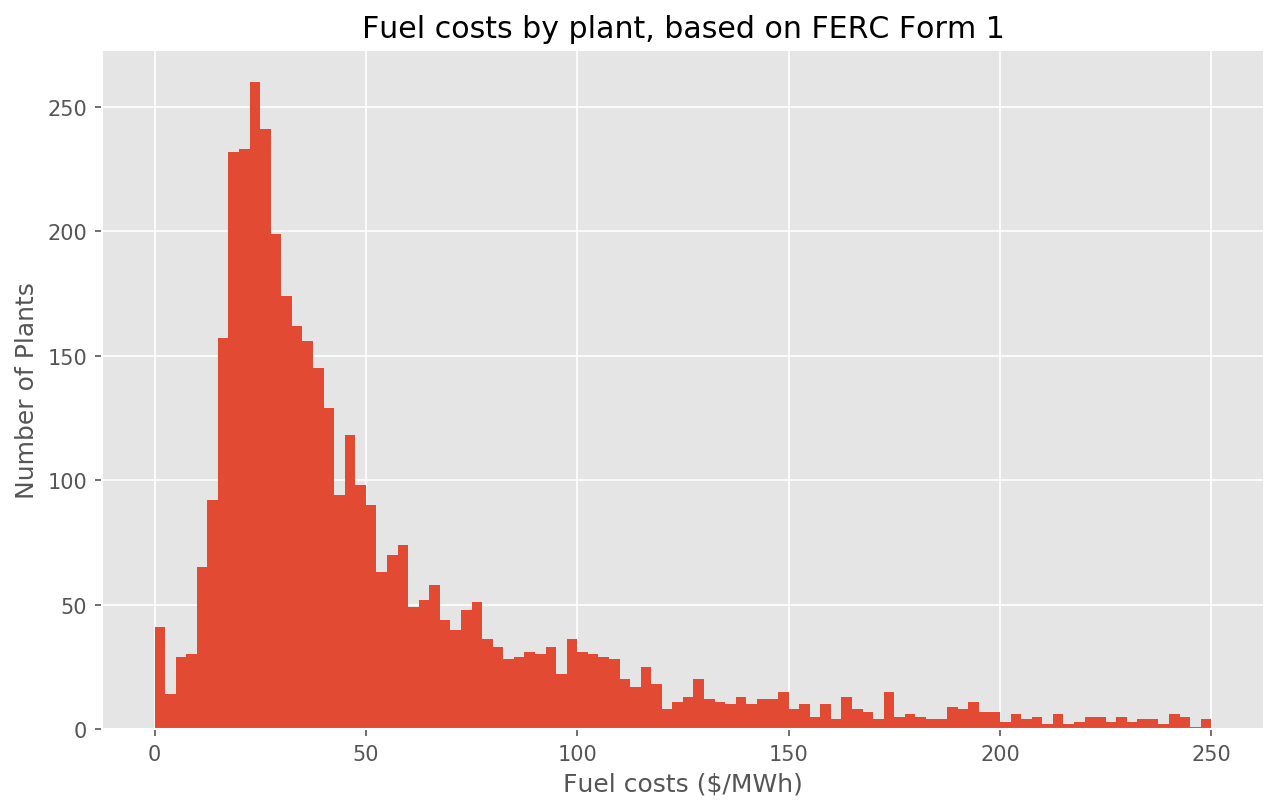

In [10]:
fig, (ax) = plt.subplots(ncols=1, nrows=1)
fig.set_figwidth(10)
fig.set_figheight(6)
fig.set_dpi(150)
plt.grid(b=True)
ax.set_ylabel("Number of Plants")
ax.set_xlabel("Fuel costs ($/MWh)")
ax.set_title("Fuel costs by plant, based on FERC Form 1")
ax.hist(ferc_merge['expns_fuel_per_mwh'], bins=100, range=(0,250));

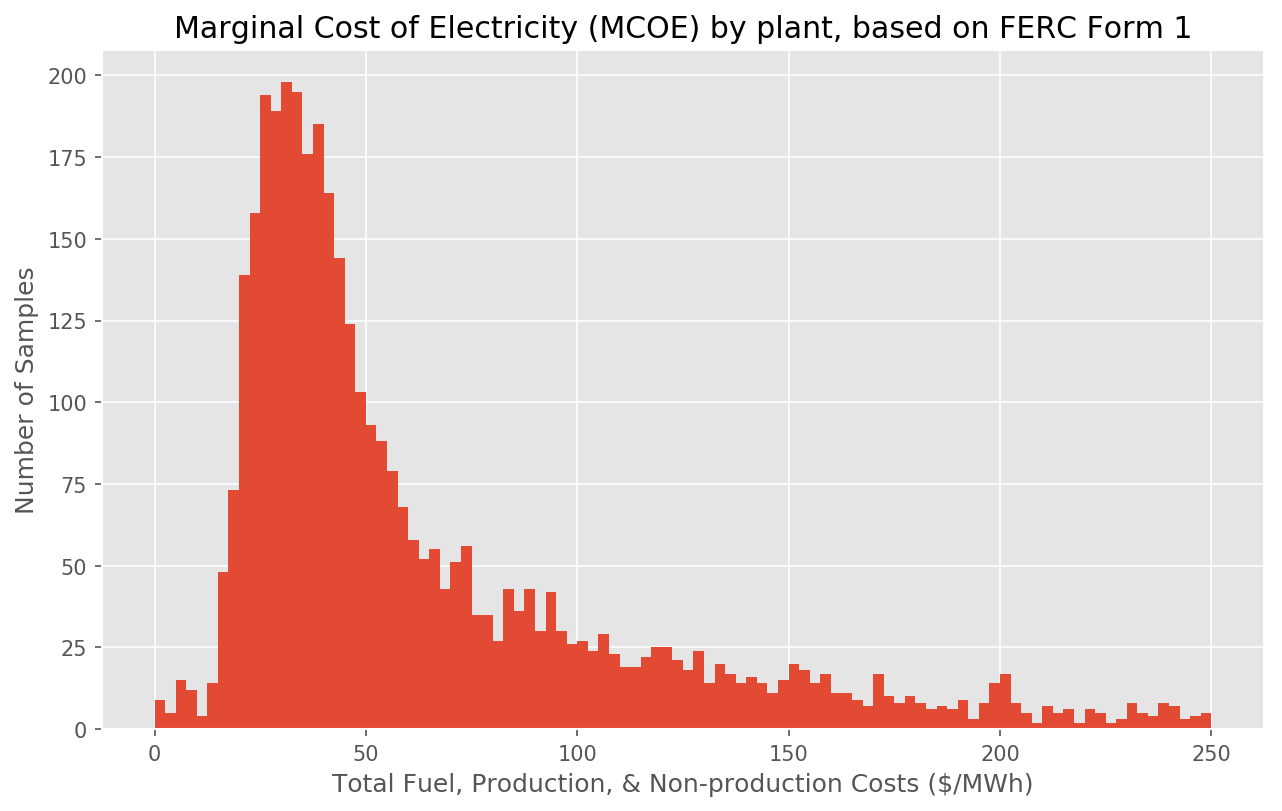

In [11]:
fig, (ax) = plt.subplots(ncols=1, nrows=1)
fig.set_figwidth(10)
fig.set_figheight(6)
fig.set_dpi(150)
ax.set_ylabel("Number of Samples")
ax.set_xlabel("Total Fuel, Production, & Non-production Costs ($/MWh)")
ax.set_title("Marginal Cost of Electricity (MCOE) by plant, based on FERC Form 1")
ax.hist(ferc_merge['expns_total_per_mwh'], bins=100, range=(0,250));
plt.grid(b=True)